In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as tt
# Import the 'get_cosine_schedule_with_warmup' function from the transformers library, a popular natural language processing (NLP) library by Hugging Face
from transformers import get_cosine_schedule_with_warmup
# Import the my_utils file used throughout the course
import my_utils as mu

In [3]:
# Assign the appropriate device for computation ('cuda' for GPU or 'cpu' for CPU) depending on the availability of a GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print('Using device:', device)
# If a GPU is available, print the name of the GPU device
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) 

Using device: cuda
Tesla P100-PCIE-16GB


In [4]:
# Data transforms (normalization & data augmentation)

# Define the batch size for the DataLoader
batch_size = 128

# Define mean and standard deviation values for normalization 
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

# Create a sequence of transformations for the training dataset
train_tfms = tt.Compose([tt.RandomHorizontalFlip(),
                         tt.RandomCrop(32, padding=4),
                         tt.ToTensor(),
                         tt.Normalize(*stats)])
# Create a sequence of transformations for the testing dataset
# Convert the PIL image to a PyTorch tensor and Normalize the image using the defined mean and standard deviation values
test_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_tfms)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_tfms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
class Block(torch.nn.Module):
    def __init__(self, k, c_in, c_out):
        super(Block, self).__init__()
        self.k = k                  # Number of convolutional branches
        self.c_in = c_in            # Input channels
        self.c_out = c_out          # Output channels
        
        # Layers and operations
        self.linear = nn.Linear(c_in, k)             # Linear layer to produce attention coefficients
        self.relu1 = nn.ReLU()                       # ReLU activation for attention coefficients
        self.relu2 = nn.ReLU()                       # ReLU activation for convolutional branches
        self.AdaptAvg = nn.AdaptiveAvgPool2d(1)      # Adaptive average pooling to create global context
        self.MaxPool = nn.MaxPool2d(2, 2)            # Max-pooling layer for convolutional branches
        self.flatten = nn.Flatten()                  # Flatten layer for input to the linear layer
        self.BatchNorm = nn.BatchNorm2d(c_out)       # Batch normalization layer for output
        self.dropout = nn.Dropout(p=0.1)             # Dropout layer for convolutional branches

        # Create k convolutional branches
        for i in range(self.k):
            self.add_module('conv{0}'.format(i), nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1))

    def forward(self, x):
        # Compute attention coefficients
        inter = self.linear(self.flatten(self.AdaptAvg(x)))
        a = self.relu1(inter)

        # Apply k convolutional branches and store their outputs
        conv_out = []
        for i in range(self.k):
            conv_out.append(self.MaxPool(self.dropout(self.relu2(self._modules['conv{0}'.format(i)](x)))))

        # Initialize variables for output computation
        b_size = x.size(dim=0)
        # A 2x2 max-pooling layer with a stride of 2; the spatial dimensions are halved.
        spat_dim = x.size(dim=2) // 2
        b_li = []
        result = torch.zeros([self.c_out, spat_dim, spat_dim]).to(device)

        # Combine the outputs of the convolutional branches using attention coefficients
        for i in range(b_size):
            for j in range(self.k):
                result.add_(a[i][j].to(device) * conv_out[j][i].to(device))
            b_li.append(result)
            result = torch.zeros([self.c_out, spat_dim, spat_dim]).to(device)

        # Stack the output tensors and apply batch normalization
        out = torch.stack(b_li)
        out = self.BatchNorm(out)
        return out

In [7]:
class Classifier(torch.nn.Module):
    def __init__(self, in_feats, out_feats):
        super(Classifier, self).__init__()
        self.in_feats = in_feats
        self.out_feats = out_feats
        self.AdaptAvg = nn.AdaptiveAvgPool2d(1)# Adaptive average pooling to create global context

        # Define the hidden layers and their sizes
        hidden_layer1_size = 256
        hidden_layer2_size = 128
        hidden_layer3_size = 64

        # Input layer to first hidden layer
        self.linear1 = nn.Linear(in_feats, hidden_layer1_size)
        self.relu1 = nn.ReLU()

        # First hidden layer to second hidden layer
        self.linear2 = nn.Linear(hidden_layer1_size, hidden_layer2_size)
        self.relu2 = nn.ReLU()

        # Second hidden layer to third hidden layer
        self.linear3 = nn.Linear(hidden_layer2_size, hidden_layer3_size)
        self.relu3 = nn.ReLU()

        # Third hidden layer to output layer
        self.linear4 = nn.Linear(hidden_layer3_size, out_feats)

    def forward(self, x):
        # Apply adaptive average pooling to the input
        out = self.AdaptAvg(x)
        # Flatten the pooled tensor
        out = out.view(-1, self.in_feats)
        
        out = self.linear1(out)
        out = self.relu1(out)

        out = self.linear2(out)
        out = self.relu2(out)

        out = self.linear3(out)
        out = self.relu3(out)

        final_out = self.linear4(out)
        
        return final_out

In [8]:
class Model(torch.nn.Module):
    def __init__(self, channels, num_of_blocks, k):
        super(Model, self).__init__()
        self.num_of_blocks = num_of_blocks
        # Create a classifier instance with the final block output channels and 10 output classes
        self.classifier = Classifier(channels[-1], 10)
        # Add a series of Block instances to the model
        for i in range(num_of_blocks):
            self.add_module('block{0}'.format(i), Block(k, channels[i], channels[i+1]))
        

    def forward(self, x):
        # Start with the input tensor
        out = x
        # Pass the tensor through each Block in the model
        for i in range(self.num_of_blocks):
            out = self._modules['block{0}'.format(i)](out)
        # Pass the output tensor through the classifier
        out = self.classifier(out)
        return out

In [9]:
def trainf(net, train_iter, test_iter, loss, num_epochs, optimizer, device): #taken from lab 9 and modified to have scheduler
    net.to(device) # Move model to device, GPU or CPU
    animator = mu.d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = mu.d2l.Timer()
    for epoch in range(num_epochs):
        metric = mu.d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            scheduler.step() # Update the learning rate
            with torch.no_grad():
                metric.add(l * X.shape[0], mu.d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0] / metric[2], metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                              (train_loss, train_acc, None))
        test_acc = mu.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [10]:
def init_weights(m):# Define a weight initialization function, taken from lab 8
    # Check if the module is an instance of nn.Linear or nn.Conv2d
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        # Initialize weights using Xavier uniform initialization
        torch.nn.init.xavier_uniform_(m.weight)

In [11]:
model = Model([3, 64, 128, 256, 512], 4, 6) # channels, N = 4, k = 6 
# Apply the weight initialization function to the model
model.apply(init_weights)

Model(
  (classifier): Classifier(
    (AdaptAvg): AdaptiveAvgPool2d(output_size=1)
    (linear1): Linear(in_features=512, out_features=256, bias=True)
    (relu1): ReLU()
    (linear2): Linear(in_features=256, out_features=128, bias=True)
    (relu2): ReLU()
    (linear3): Linear(in_features=128, out_features=64, bias=True)
    (relu3): ReLU()
    (linear4): Linear(in_features=64, out_features=10, bias=True)
  )
  (block0): Block(
    (linear): Linear(in_features=3, out_features=6, bias=True)
    (relu1): ReLU()
    (relu2): ReLU()
    (AdaptAvg): AdaptiveAvgPool2d(output_size=1)
    (MaxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (BatchNorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=

In [12]:
learning_rate = 0.001
warmup_epochs = 5
total_epochs = 50
steps_per_epoch = len(trainloader.dataset) // trainloader.batch_size
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# Create a scheduler with cosine annealing and warmup
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_epochs * steps_per_epoch, num_training_steps=total_epochs * steps_per_epoch)

loss 0.035, train acc 0.988, test acc 0.896
225.4 examples/sec on cuda


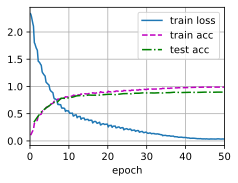

In [13]:
trainf(model, trainloader, testloader, loss, total_epochs, optimizer, device)